## Pseudo-labeling Semisupervised Learning

Because I am only able to confidently label a small portion of the larger Bexar property dataset, pseudo-labeling can be a way to train a model on the larger dataset. First I train a series of models on the small, labeled data. Then I use that trained model to label the far-larger unlabeled dataset. Lastly, I can then train a new model on a dataset containing both the original, labeled data and the new, pseudo-labeled data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.simplefilter('ignore')
from joblib import dump, load

from sklearn.svm import SVC
from sklearn.utils import shuffle
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, make_scorer, f1_score

#### Load Data and Separate Labeled and Unlabeled Dataframes

In [2]:
# Read in data
labeled_df = pd.read_hdf('../data/processed/bexar_true_labels.h5')
all_df = pd.read_hdf('../data/processed/bexar_processed.h5')

In [3]:
# Trim to just the data needed for modeling
all_df['price_psf'] = all_df['price_psf'].fillna(0)
# Trim outlier properties
trim_prop_df = all_df[(all_df.price_psf<all_df.price_psf.quantile(.999))]

nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()
variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value',
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

# Drop columns
sub_df = trim_prop_df[variables_list]
sub_df = sub_df.dropna()

In [4]:
# Grab only properties not already in the labeled dataset
unlabeled_df = sub_df[~(sub_df['prop_id'].isin(labeled_df.prop_id))]

X_labeled = labeled_df.iloc[:,1:-1]
y_labeled = labeled_df.crim_prop
X_unlabeled = unlabeled_df.iloc[:,1:-1]

In [5]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.25, random_state=3
)

In [6]:
# List of models to try
models = [
    SVC(),
    XGBClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()
]

for model in models:
    print(type(model).__name__,'\n')
    model.seed = 42
    num_folds = 5

    scores = cross_val_score(model, X_train, y_train, cv=num_folds)
    
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    print('Conf matrix for training data:')
    print(confusion_matrix(y_train,y_pred_train,labels=[1,0]))
    print('Recall is',recall_score(y_train,y_pred_train))
    print('Precision is',precision_score(y_train,y_pred_train))
    print("CV scores:",scores,'\n')
    
    y_pred = model.predict(X_test)
    print('Conf matrix for test data:')
    print(confusion_matrix(y_test,y_pred,labels=[1,0]))
    print('Recall is',recall_score(y_test,y_pred))
    print('Precision is',precision_score(y_test,y_pred,zero_division=1),'\n'*2,'*'*40,'\n')

SVC 

Conf matrix for training data:
[[   1   32]
 [   0 4139]]
Recall is 0.030303030303030304
Precision is 1.0
CV scores: [0.99161677 0.99161677 0.99280576 0.99280576 0.99160671] 

Conf matrix for test data:
[[   0   14]
 [   0 1377]]
Recall is 0.0
Precision is 1.0 

 **************************************** 

XGBClassifier 

Conf matrix for training data:
[[  33    0]
 [   0 4139]]
Recall is 1.0
Precision is 1.0
CV scores: [0.99520958 0.99401198 0.99640288 0.99640288 0.99520384] 

Conf matrix for test data:
[[   6    8]
 [   0 1377]]
Recall is 0.42857142857142855
Precision is 1.0 

 **************************************** 

RandomForestClassifier 

Conf matrix for training data:
[[  33    0]
 [   0 4139]]
Recall is 1.0
Precision is 1.0
CV scores: [0.99401198 0.99401198 0.99520384 0.99640288 0.9940048 ] 

Conf matrix for test data:
[[   4   10]
 [   0 1377]]
Recall is 0.2857142857142857
Precision is 1.0 

 **************************************** 

GradientBoostingClassifier 

Conf m

Gradient Boosting appears to be the most robust.

In [7]:
# Train model
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [8]:
# Predict pseudo-labels on unlabeled data
pseudo_labels = gbc.predict(X_unlabeled)

# Add pseudo-labels to test
augmented_test = X_unlabeled.copy(deep=True)
augmented_test['crim_prop'] = pseudo_labels

In [9]:
# Take a fraction of the pseudo-labeled data to combine with the labeled training data
sampled_test = augmented_test.sample(frac=.4,random_state=42)
print('Length of pseudo-labeled data:',len(sampled_test))

Length of pseudo-labeled data: 231222


In [10]:
# Re-merge
temp_labeled = pd.concat([X_labeled,y_labeled],axis=1)
# Concat labeled data with pseudo-labeled data
augmented_labeled = pd.concat([sampled_test,temp_labeled])

In [11]:
X_aug = augmented_labeled.iloc[:,:-1]
y_aug = augmented_labeled.crim_prop

In [12]:
scoring = {
    'AUC': 'roc_auc',
    'Recall': make_scorer(recall_score,pos_label=1),
    'Precision': make_scorer(precision_score,pos_label=1)
}
gs = GradientBoostingClassifier()
grid = {
    'max_depth': [2,3,4],
    'n_estimators': [75,100],
    'max_features': ['auto','sqrt']
}

gbc_gs = GridSearchCV(gs, grid, cv=3, scoring=scoring, refit='Recall')
gbc_gs.fit(X_aug, y_aug)
print('Model gridsearched and trained')

Model gridsearched and trained


In [13]:
print('Best parameters:',gbc_gs.best_params_)

Best parameters: {'max_depth': 4, 'max_features': 'auto', 'n_estimators': 100}


In [14]:
y_pred_train = gbc_gs.predict(augmented_labeled.iloc[:,:-1])

# Evaluate performance
print(confusion_matrix(augmented_labeled.crim_prop,y_pred_train,labels=[1,0]))
print('Recall:',recall_score(augmented_labeled.crim_prop,y_pred_train))
print('Precision:',precision_score(augmented_labeled.crim_prop,y_pred_train))
print('F1 Score:',f1_score(augmented_labeled.crim_prop,y_pred_train))

[[ 10949    602]
 [   364 224870]]
Recall: 0.9478833001471734
Precision: 0.9678246265358437
F1 Score: 0.9577501749475157


In [15]:
# Save the model
# dump(gbc_gs, '../models/gbc_gs.joblib')

#### Feature Importance

In [16]:
# Grab features, sort by index
feature_importance = gbc_gs.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
features = X_aug.columns

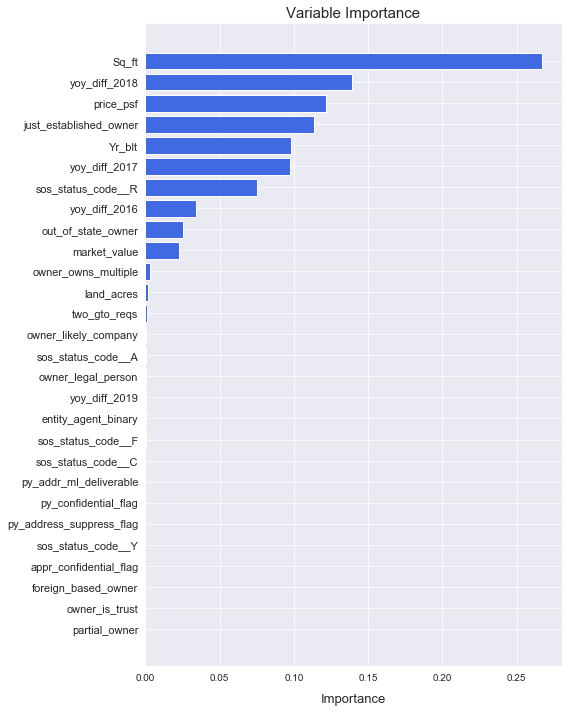

In [17]:
# Plot
plt.figure(figsize=(8,10))
pos = np.arange(sorted_idx.shape[0]) + .5

plt.barh(pos, feature_importance[sorted_idx],color='royalblue')
plt.yticks(pos, features[sorted_idx],fontsize=11)
plt.xlabel('Importance',labelpad=10,fontsize=13)
plt.title('Variable Importance',fontsize=15)
# plt.savefig('../data/figures/gbc_variable_importance.png')
plt.tight_layout()
plt.show()

#### Final Notes

- Every model struggles to adapt from the training data to the test data.
- Gradient Boosting appears to be the most robust.
- Using pseudolabels from 40% of the unlabeled data creates a good Gradient Boosting model that performs well in precision, recall, and f1 score.
- For the GBC, the most important features are raw square footage of the property, YoY difference in price change since 2018, and a property owner that is a recently-established (within the year of purchase) company